### Pavel Furch, učo: 415339

### Masarykova univerzita, jarní semestr 2023
### Datamining: úkol č. 2

#### Pozn.: Úkol jsem zaznamenal do Jupyter notebook, který umožňuje zobrazovat výstupy kódu.

In [1]:
library(tidyverse)
library(tidytext)
library(gutenbergr)
library(lubridate)
library(rpart)
library(rpart.plot)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.0     v purrr   1.0.1
v tibble  3.1.8     v dplyr   1.1.0
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.3     v forcats 1.0.0
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [2]:
# Ukol 1: Stahnuti vybrane knihy ------------------------------------------
book <- gutenberg_download(925)

Determining mirror for Project Gutenberg from https://www.gutenberg.org/robot/harvest

Using mirror http://aleph.gutenberg.org



In [3]:
# Ukol 2: Rozdeleni knihy na jednotlive proslovy ------------------------

speeches <- book %>% 
  mutate(speech_id = cumsum(str_detect(text, "\\*\\s\\*\\s\\*\\s\\*\\s\\*"))) %>% # oddeleni jednotlivych proslovu
  filter(!speech_id %in% c(0,56)) %>% # odstraneni prvni a posledni sekce, ktere nejsou proslovy 
  filter(text != "") %>% # odstraneni prazdnych radku
  group_by(speech_id) %>% 
  mutate(line = row_number(), # cislo radku v ramci jednoho proslovu
         note_start = cumsum(str_detect(text, "\\[")), # oznaceni zacatku poznamky
         note_end = lag(cumsum(str_detect(text, "\\]")))) %>% # oznaceni konce poznamky
  filter(!((note_start == 1)&(note_end == 0))) %>% # odstraneni poznamky
  select(text, speech_id, line) # vybrani jenom sloupcu s textem, identifikatorem reci a poradim radku


In [4]:
# Extrakce jmena prezidenta
presidents <- speeches %>% 
  filter(line == 2) %>% # vybrani radku s jmenem prezidenta
  mutate(president = str_extract(text, "^([A-Z.\\s]*)(?=(,\\s)?(FIRST\\s|SECOND\\s|THIRD\\s|FOURTH\\s)?INAUGURAL)"),
         name = str_remove(president, "\\s(FIRST|SECOND)\\s")) %>% 
  select(speech_id, name)

In [205]:
(table(speeches$speech_id))

head(presidents)


  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20 
125  13 205 149 192 104 106 295 390 257 104 106 345 725 425 100 294 250 315  58 
 21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40 
 99 118 227 275 155 392 189 345 198  81 481 141 127 307 351 356 166 165 125  52 
 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55 
231 221 152 122 137 197 166 113 211 228 191 139 193 153 184 

speech_id,name
<int>,<chr>
1,GEORGE WASHINGTON
2,GEORGE WASHINGTON
3,JOHN ADAMS
4,THOMAS JEFFERSON
5,THOMAS JEFFERSON
6,JAMES MADISON


In [6]:
# Extrakce data proslovu
dates <- speeches %>% 
  filter(line == 3) %>% # vybrani radku s mistem konani
  mutate(date_of_speech = mdy(str_extract(text, "(JANUARY|MARCH|APRIL)\\s\\d{1,2},\\s\\d{4}"))) %>% # extrakce data
  select(speech_id, date_of_speech)

In [145]:
head(speeches)

text,speech_id,line
<chr>,<int>,<int>
Fellow-Citizens of the Senate and of the House of Representatives:,1,15
Among the vicissitudes incident to life no event could have filled me,1,16
with greater anxieties than that of which the notification was,1,17
"transmitted by your order, and received on the 14th day of the present",1,18
"month. On the one hand, I was summoned by my Country, whose voice I can",1,19
"never hear but with veneration and love, from a retreat which I had",1,20


In [202]:
speeches %>% 
  filter(line == 1)

dim(speeches)

text,speech_id,line
<chr>,<int>,<int>


[1] 11546     3

In [203]:
head(dates)

speech_id,date_of_speech
<int>,<date>
1,1789-04-30
2,1793-03-04
3,1797-03-04
4,1801-03-04
5,1805-03-04
6,1809-03-04


In [9]:
# Odstraneni hlavicky se jmenem prezidenta a mistem projevu
speeches <- speeches %>% 
  filter(line > 3)

In [224]:
# Ukol 3: Tokenizace na slova -------------------------------------------

speeches_words <- speeches %>%
  unnest_tokens(word,text)

head(speeches)

text,speech_id,line
<chr>,<int>,<int>
Fellow-Citizens of the Senate and of the House of Representatives:,1,15
Among the vicissitudes incident to life no event could have filled me,1,16
with greater anxieties than that of which the notification was,1,17
"transmitted by your order, and received on the 14th day of the present",1,18
"month. On the one hand, I was summoned by my Country, whose voice I can",1,19
"never hear but with veneration and love, from a retreat which I had",1,20


In [194]:
# Ukol 4: Odstraneni stop-words -------------------------------------------

speeches_words <- speeches_words %>% 
  anti_join(stop_words)

head(speeches_words)

Joining with `by = join_by(word)`


speech_id,word
<int>,<chr>
1,fellow
1,citizens
1,senate
1,house
1,representatives
1,vicissitudes


In [12]:
# Ukol 5: Vypocet poctu vsech a unikatnich slov ---------------------------

speeches_features <- speeches_words %>% 
  group_by(speech_id) %>% 
  summarise(no_words = length(word), # pocet vsech slov
            unique_words = n_distinct(word))   # pocet unikatnich slov

In [13]:
# Ukol 6: Vypocitani sentimentu NRC ---------------------------------------

install.packages("textdata")
library(textdata)

speeches_sentiment <- speeches_words %>% 
  inner_join(get_sentiments("nrc")) %>% # spojeni se sentimentovym slovnikem NRC
  count(speech_id, sentiment) %>% # pocet slov pro kazdy proslov a sentiment
  pivot_wider( # prevedeni do wider formatu (v radcich jsou proslovy, ve sloupcich sentimenty)
    names_from = sentiment,
    values_from = n)

Installing package into 'C:/Users/pfurch/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



package 'textdata' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\pfurch\AppData\Local\Temp\RtmpspmZTo\downloaded_packages


Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("nrc")):
"Each row in `x` is expected to match at most 1 row in `y`.
i Row 1 of `x` matches multiple rows.
i If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [192]:
# Ukol 7: Spojeni vsech informaci do jednoho datasetu ---------------------

# prislusnost prezidentu k politicke strane
# prevzato z https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States
parties <- tibble(name = unique(presidents$name),
                  party = c("Unaffiliated", "Federalist", "Democratic-Republican", "Democratic-Republican",
                            "Democratic-Republican", "Democratic-Republican", "Democratic", "Democratic",
                            "Whig", "Democratic", "Whig", "Democratic", "Democratic", "Republican", 
                            "Republican", "Republican", "Republican", "Democratic", "Republican", "Republican",
                            "Republican", "Republican", "Democratic", "Republican", "Republican", "Republican", 
                            "Democratic", "Democratic", "Republican", "Democratic", "Democratic", "Republican",
                            "Democratic", "Republican", "Republican", "Democratic", "Republican"))

head(parties)

name,party
<chr>,<chr>
GEORGE WASHINGTON,Unaffiliated
JOHN ADAMS,Federalist
THOMAS JEFFERSON,Democratic-Republican
JAMES MADISON,Democratic-Republican
JAMES MONROE,Democratic-Republican
JOHN QUINCY ADAMS,Democratic-Republican


In [16]:
speeches_final <- speeches_features %>% 
  left_join(speeches_sentiment) %>% # pripojeni sentimentu
  left_join(presidents) %>% # pripojeni jmena prezidenta 
  left_join(dates) %>% # pripojeni data projevu        !!!!!!!
  left_join(parties) %>% # pripojeni politicke strany
  mutate(across(unique_words:trust, ~ (./no_words*100))) # vydeleni poctu slov pro dany sentiment poctem vsech slov projevu

Joining with `by = join_by(speech_id)`
Joining with `by = join_by(speech_id)`
Joining with `by = join_by(speech_id)`
Joining with `by = join_by(name)`


In [198]:
# Odzkoušení parametrů funkce pivot_longer na menším datasetu

df <- data.frame(player=c('A', 'B', 'C', 'D'),
                 year1=c(12, 15, 19, 19),
                 year2=c(22, 29, 18, 12))
df

df %>% pivot_longer(cols=c('year1', 'year2'),
                    names_to='year',
                    values_to='points')

player,year1,year2
<chr>,<dbl>,<dbl>
A,12,22
B,15,29
C,19,18
D,19,12


player,year,points
<chr>,<chr>,<dbl>
A,year1,12
A,year2,22
B,year1,15
B,year2,29
C,year1,19
C,year2,18
D,year1,19
D,year2,12


In [49]:
# Ukol 8: Vykresleni sentimentu v case

speeches_final %>% 
  select(date_of_speech, party, anger, anticipation,disgust,fear,joy,
         negative,positive,sadness,surprise,trust)  %>%
  pivot_longer(cols = c("anger","anticipation","disgust","fear","joy",
                        "negative","positive","trust"), 
           names_to = "sentiment",
           values_to = "hodnota"
              )

date_of_speech,party,sadness,surprise,sentiment,hodnota
<date>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1789-04-30,Unaffiliated,2.457467,2.079395,anger,1.701323
1789-04-30,Unaffiliated,2.457467,2.079395,anticipation,7.561437
1789-04-30,Unaffiliated,2.457467,2.079395,disgust,1.134216
1789-04-30,Unaffiliated,2.457467,2.079395,fear,4.725898
1789-04-30,Unaffiliated,2.457467,2.079395,joy,7.183365
1789-04-30,Unaffiliated,2.457467,2.079395,negative,7.939509
1789-04-30,Unaffiliated,2.457467,2.079395,positive,20.982987
1789-04-30,Unaffiliated,2.457467,2.079395,trust,12.665406
1793-03-04,Unaffiliated,1.960784,1.960784,anger,3.921569


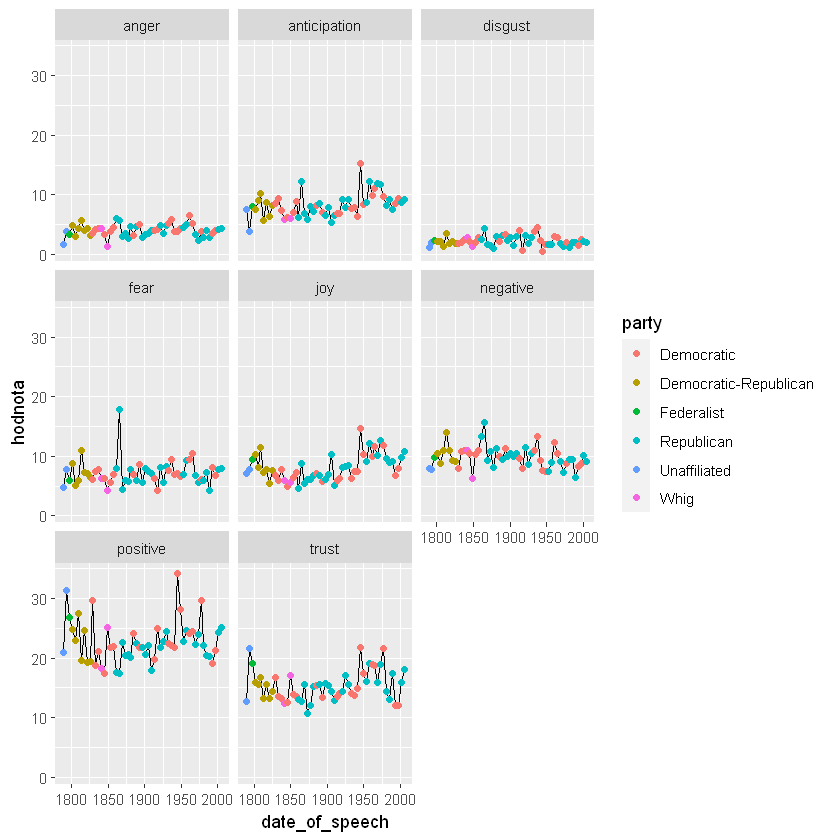

In [77]:
speeches_final %>% 
  select(date_of_speech, party, anger, anticipation,disgust,fear,joy,
         negative,positive,sadness,surprise,trust)  %>%
  pivot_longer(cols = c("anger","anticipation","disgust","fear","joy",
                        "negative","positive","trust"), 
               names_to = "sentiment",
               values_to = "hodnota"
  ) %>% 
  ggplot(aes(x=date_of_speech, y=hodnota)) + # na horizontalni ose bude 
  geom_line() +
  geom_point(aes(color=party)) +  # pridejte body v barve politicke strany
  facet_wrap(~sentiment) # rozdelte graf na zaklade sentimentu

In [195]:
# Ukol 9: Klasifikace prezidentu do politicke strany pomoci rozhodovaciho stromu

# nastaveni generatoru pseudo-nahodnych cisel

set.seed(42)

temp <- speeches_final %>% 
  filter(party %in% c("Democratic", "Republican")) %>% # vyberte jenom prezidenty z demokraticke a republikanske strany
  select(c(no_words:trust, party))

head(temp)

no_words,unique_words,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,party
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
448,84.59821,3.571429,8.482143,1.785714,6.026786,6.696429,8.035714,29.68750,2.008929,2.455357,16.74107,Democratic
433,74.59584,4.157044,9.468822,2.078522,7.390300,6.004619,10.854503,18.70670,3.695150,2.771363,13.62587,Democratic
1505,66.64452,4.318937,7.441860,2.458472,7.774086,7.840532,11.029900,21.12957,3.920266,2.524917,13.28904,Democratic
1847,55.54954,3.410937,6.280455,2.165674,6.334597,4.981050,10.395236,17.48782,2.707093,1.894965,12.61505,Democratic
1253,70.31125,3.830806,7.102953,1.995211,5.666401,6.384677,10.375100,21.78771,3.671189,2.553871,13.80686,Democratic
1063,63.59360,4.609595,8.936971,2.822201,6.961430,7.337723,10.912512,21.91910,4.139229,2.728128,13.54657,Democratic


In [100]:
set.seed(42)

model_speeches <- rpart(party ~ anger+anticipation+disgust+fear+
                        joy+negative+positive+sadness+surprise+trust, 
                        data = temp) 
# odhad rozhodovaciho stromu, 
# odhadujete politickou prislusnost na zaklade textovych promennych

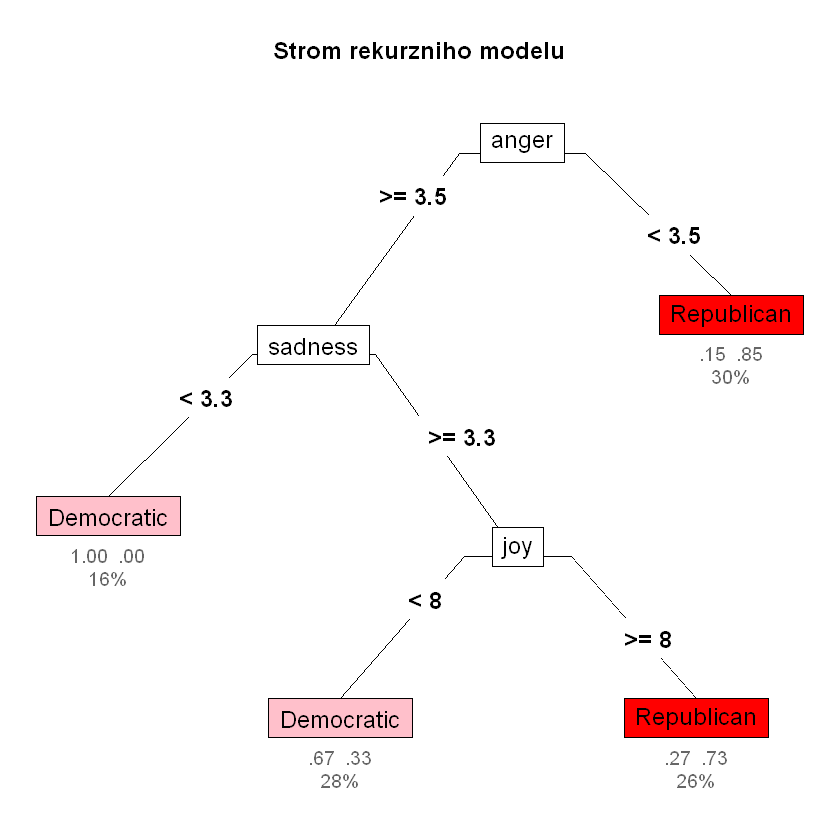

In [219]:
rpart.plot(model_speeches, # vykreslete strom
           type = 5, 
           extra = 104,
           box.palette = list(
             Republican = "pink",
             Democratic = "red"),
           leaf.round = 0,
           fallen.leaves = F, 
           branch = 0.3, 
           under = TRUE,
           under.col = "grey40",
           main = "Strom rekurzniho modelu",
           tweak = 1.2)

In [113]:
# Ukol 10: Overeni modelu na poslednich 3 prezidentech

new_speeches <- read_csv("new_speeches.csv") # nactete csv soubor s projevy poslednich tri americkych prezidentu

Rows: 4 Columns: 3
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr (3): name, date_of_speech, text

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [115]:
class(new_speeches)

[1] "spec_tbl_df" "tbl_df"      "tbl"         "data.frame"

In [152]:
new_speeches_words <- new_speeches %>% 
  mutate(speech_id = mdy(str_extract(date_of_speech, "(January)\\s\\d{1,2},\\s\\d{4}"))) %>% 
  unnest_tokens(word,text) %>% 
  anti_join(stop_words) 

head(new_speeches_words)

Joining with `by = join_by(word)`


name,date_of_speech,speech_id,word
<chr>,<chr>,<date>,<chr>
BARACK OBAMA,"January 20, 2009",2009-01-20,fellow
BARACK OBAMA,"January 20, 2009",2009-01-20,citizens
BARACK OBAMA,"January 20, 2009",2009-01-20,stand
BARACK OBAMA,"January 20, 2009",2009-01-20,humbled
BARACK OBAMA,"January 20, 2009",2009-01-20,task
BARACK OBAMA,"January 20, 2009",2009-01-20,grateful


In [ ]:
new_speeches$speech_id

In [151]:
new_speeches_words <- new_speeches %>% 
  mutate(speech_id = row_number()) %>% # cislo radku v ramci jednoho proslovu  
  unnest_tokens(word,text) %>% 
  anti_join(stop_words) 

head(new_speeches_words)
tail(new_speeches_words)

Joining with `by = join_by(word)`


name,date_of_speech,speech_id,word
<chr>,<chr>,<int>,<chr>
BARACK OBAMA,"January 20, 2009",1,fellow
BARACK OBAMA,"January 20, 2009",1,citizens
BARACK OBAMA,"January 20, 2009",1,stand
BARACK OBAMA,"January 20, 2009",1,humbled
BARACK OBAMA,"January 20, 2009",1,task
BARACK OBAMA,"January 20, 2009",1,grateful


name,date_of_speech,speech_id,word
<chr>,<chr>,<int>,<chr>
"JOSEPH R. BIDEN, JR.","January 20, 2021",4,bless
"JOSEPH R. BIDEN, JR.","January 20, 2021",4,america
"JOSEPH R. BIDEN, JR.","January 20, 2021",4,god
"JOSEPH R. BIDEN, JR.","January 20, 2021",4,protect
"JOSEPH R. BIDEN, JR.","January 20, 2021",4,troops
"JOSEPH R. BIDEN, JR.","January 20, 2021",4,america


In [178]:
new_speeches_features <- new_speeches_words %>% 
  group_by(speech_id) %>% 
  summarise(no_words = length(word),
            unique_words = n_distinct(word))

new_speeches_features

[1] "space without limits"

[1] 2

speech_id,no_words,unique_words
<date>,<int>,<int>
2009-01-20,906,681
2013-01-21,849,601
2017-01-20,544,374
2021-01-20,823,519


In [199]:
new_speeches_sentiment <- new_speeches_words %>% 
  inner_join(get_sentiments("nrc")) %>% 
  count(speech_id, sentiment) %>% 
  pivot_wider(
    names_from = sentiment,
    values_from = n
  )


new_speeches_sentiment

Joining with `by = join_by(word)`
Warning message in inner_join(., get_sentiments("nrc")):
"Each row in `x` is expected to match at most 1 row in `y`.
i Row 1 of `x` matches multiple rows.
i If multiple matches are expected, set `multiple = "all"` to silence this warning."


speech_id,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
<date>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2009-01-20,46,77,27,68,86,96,206,42,41,137
2013-01-21,37,73,15,65,105,71,197,28,55,128
2017-01-20,17,40,8,28,46,31,111,12,12,80
2021-01-20,52,62,14,65,55,96,160,44,22,116


In [200]:
new_speeches_final <- new_speeches_features %>% 
  left_join(new_speeches_sentiment) %>% # pripojeni segmenti
  mutate(across(unique_words:trust, ~ (./no_words*100))) # vydeleni poctu slov pro dany sentiment poctem vsech slov projevu

new_speeches_final

Joining with `by = join_by(speech_id)`


speech_id,no_words,unique_words,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2009-01-20,906,75.16556,5.077263,8.498896,2.980132,7.505519,9.492274,10.596026,22.73731,4.635762,4.525386,15.12141
2013-01-21,849,70.78916,4.358068,8.598351,1.766784,7.656066,12.367491,8.362780,23.20377,3.297998,6.478210,15.07656
2017-01-20,544,68.75000,3.125000,7.352941,1.470588,5.147059,8.455882,5.698529,20.40441,2.205882,2.205882,14.70588
2021-01-20,823,63.06197,6.318348,7.533414,1.701094,7.897934,6.682868,11.664642,19.44107,5.346294,2.673147,14.09478


In [209]:
new_speeches$name

[1] "BARACK OBAMA"         "BARACK OBAMA"         "DONALD TRUMP"        
[4] "JOSEPH R. BIDEN, JR."

In [218]:
speech_prediction <- predict(object = model_speeches, newdata = new_speeches_final) # udelejte predikce

speech_prediction %>% 
  bind_cols(new_speeches$name) # pridani jmen k predikcim

New names:
* `` -> `...3`


Democratic,Republican,...3
<dbl>,<dbl>,<chr>
0.2727273,0.7272727,BARACK OBAMA
1.0000000,0.0000000,BARACK OBAMA
0.1538462,0.8461538,DONALD TRUMP
0.6666667,0.3333333,"JOSEPH R. BIDEN, JR."
